In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycwt as wavelet
from pycwt.helpers import find
from matplotlib.pyplot import MultipleLocator

In [16]:
url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
dat = np.genfromtxt(url, skip_header=19)
print(dat.shape)

(504,)


In [6]:
title = 'NINO3 Sea Surface Temperature'   # 标题
label = 'NINO3 SST'                       # 标签 
units = 'degC'                            # 单位
t0 = 1871.0                               # 开始的时间，以年为单位
dt = 0.25                                 # 采样间隔，以年为单位
N = dat.size                              # 时间序列的长度
t = np.arange(0, N) * dt + t0             # 构造时间序列数组

In [19]:
p = np.polyfit(t - t0, dat, 1) 

In [7]:
p = np.polyfit(t - t0, dat, 1)               # 线性拟合
dat_notrend = dat - np.polyval(p, t - t0)    # 去趋势
std = dat_notrend.std()                      # 标准差
var = std ** 2                               # 方差
dat_norm = dat_notrend / std                 # 标准化

In [8]:
mother = wavelet.Morlet(6)      # Monther Wavelet: Morlet 
s0 = 2 * dt                     # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 0.25                       # Twelve sub-octaves per octaves
J = 7 / dj                      # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

In [9]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [10]:
power = np.power(np.abs(wave),2)
fft_power = np.power(np.abs(fft),2)
period = 1 / freqs
#power /= scales[:,None]

In [11]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [12]:
glbl_power = power.mean(axis=1)
dof = N - scales                   # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [13]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(
    var, dt, scales, 2, alpha,
    significance_level=0.95,
    dof=[scales[sel[0]],
    scales[sel[-1]]],
    wavelet=mother
)

C:\Main\Soft\Conda\envs\DF_process\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


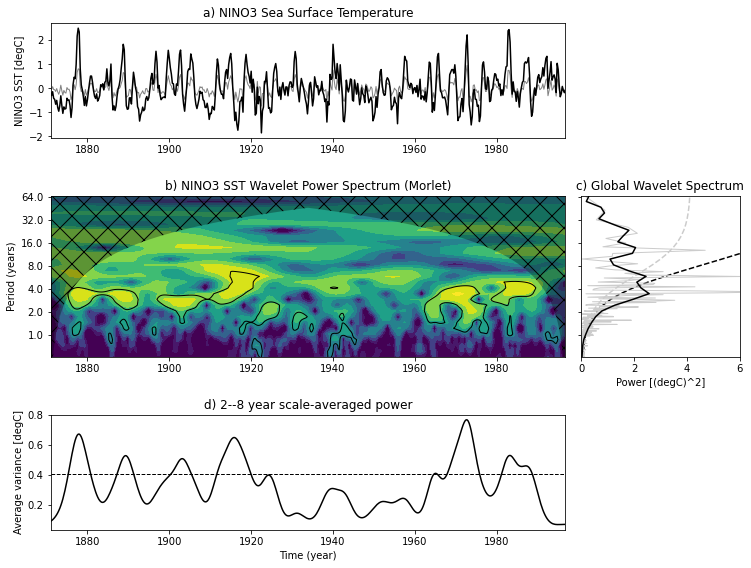

In [14]:
# Prepare the figure
fig = plt.figure(figsize=(11, 8))

# First sub-plot, the original time series anomaly and inverse wavelet transform.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), extend='both', cmap=plt.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=1, extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1/fftfreqs), '-', color='#cccccc',linewidth=1)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, 6])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])
plt.savefig('wavelet_analysis.jpg',dpi=600)
plt.show()